In [1]:
##############################################
##### PARTIE 1 : IMPORTATION DES DONNEES #####
##############################################

In [2]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [ ]:
# Dans cette partie, on importe des données relatives aux risques (pollutions industrielles, inondations, qualité de l'air, sites pollués) et le tableau descriptif
# des communes tel que mis à disposition par l'INSEE.
# L'objectif est de faire la jointure est ces deux types de sources.

In [3]:
# Importation des modules utiles pour cette partie

import requests
import zipfile
import openpyxl

import pandas as pd
import geopandas as gpd

In [4]:
#### On importe le fichier répertoriant les installations industrielles rejetant des polluants, disponible sur Géorisques

# On télécharge le fichier avec la localisation des installations industrielles rejetant des polluants, directement depuis le site Géorisques
url_industries_polluantes = "https://files.georisques.fr/irep/2023.zip"
response_industries_polluantes = requests.get(url_industries_polluantes)

# On enregistre le dossier localement
with open("Industries_polluantes.xlsx", "wb") as f:
    f.write(response_industries_polluantes.content)

# On importe le fichier répertoriant les établissements polluants (qui est une liste des établissements)
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/etablissements.csv") as f:
        industries_polluantes = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee dès maintenant (pour harmoniser ensuite)
industries_polluantes = industries_polluantes.rename(columns={"code_insee" : "insee"})
industries_polluantes.head()

# On importe le fichier des rejets (pour chaque établissement listé dans industries_polluantes)
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/rejets.csv") as f:
        rejets = pd.read_csv(f, sep=None, engine='python')
rejets = rejets.rename(columns = {"code_insee" : "insee"})
rejets.head()

# On fusionne les deux tables
etablissements_rejets = pd.merge(industries_polluantes, rejets, on=["identifiant", "nom_etablissement", "code_postal", "insee",
"commune", "code_departement", "departement", "code_region", "region"], how="inner")

# On obtient les variables d'intérêt suivantes :
# nom de l'établissement (pour le versant établissements);
# année des rejets, total des rejets raccordés au réseau, total des rejets isolés (pour le versant rejets)
etablissements_rejets.columns

# On regroupe par la commune et on enregistre les pollutions (total des rejets ET nombre d'établissements)
etablissements_rejets_agr = etablissements_rejets.groupby("insee").agg(
    rejets_isoles=("rejet_isole_m3_par_an", "sum"),
    nb_etablissements_isoles=("rejet_isole_m3_par_an", "count"),
    rejets_raccordes=("rejet_raccorde_m3_par_an", "sum"),
    nb_etablissements_raccordes=("rejet_raccorde_m3_par_an", "count")).reset_index()

# On fait, pour chaque commune, la somme des rejets raccordés et isolés pour les deux colonnes concernées
etablissements_rejets_agr["rejets_tot"] = etablissements_rejets_agr["rejets_isoles"] + etablissements_rejets_agr["rejets_raccordes"]
etablissements_rejets_agr["nb_etablissements_tot"] = etablissements_rejets_agr["nb_etablissements_isoles"] + etablissements_rejets_agr["nb_etablissements_raccordes"]

In [5]:
#### On importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9..."


In [6]:
# On essaye de créer dupliquer les colonnes Paris, Lyon et Marseille pour voir

communes_ext = communes.copy()

## Pour Paris

# On enregistre la ligne de Paris
communes_paris = communes_ext[communes_ext["insee"] == "75056"]

# On la copie 20 fois
communes_paris_20 = communes_paris.loc[communes_paris.index.repeat(20)].copy()

# On change uniquement la colonne insee (on changera les autres plus tard selon les besoins)
communes_paris_20["insee"] = [f"751{str(i).zfill(2)}" for i in range(1, 21)]    #f" permet d'insérer une variable dans une chaîne, str(i) convertit les chiffres et zfill ajoute des zéros à gauche pour le code insee

# On ajoute nos lignes au df original
i = communes_paris.index[0]         # on récupère la position de la ligne de Paris
communes_ext = pd.concat(                       # on assemble deux df aux colonnes identiques via pd.concat
    [communes_ext.iloc[:i+1], communes_paris_20, communes_ext.iloc[i+1:]],       # toutes nos lignes jusqu'à Paris - puis Paris - puis tout le reste 
    ignore_index=True
)

## Idem pour Lyon
communes_lyon = communes_ext[communes_ext["insee"] == "69123"]
communes_lyon_20 = communes_lyon.loc[communes_lyon.index.repeat(9)].copy()
communes_lyon_20["insee"] = [f"6938{str(i)}" for i in range(1, 10)]

j = communes_lyon.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:j+1], communes_lyon_20, communes_ext.iloc[j+1:]],
    ignore_index=True
)

## Et pour Marseille
communes_marseille = communes_ext[communes_ext["insee"] == "13055"]
communes_marseille_20 = communes_marseille.loc[communes_marseille.index.repeat(16)].copy()
communes_marseille_20["insee"] = [f"132{str(i).zfill(2)}" for i in range(1, 17)]

k = communes_marseille.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:k+1], communes_marseille_20, communes_ext.iloc[k+1:]],
    ignore_index=True
)

In [7]:
### On fait une première fusion entre les communes et les pollutions industrielles

# On fait la jointure (en ne conservant que les communes qui sont dans les deux df, ie celles qui ont des rejets identifiés)
communes_rejets = pd.merge(communes_ext, etablissements_rejets_agr, on="insee", how = "inner")

# Conversion du fichier au format GeoPandas
communes_rejets = gpd.GeoDataFrame(communes_rejets, geometry='geometry')

# On crée un df avec les communes et une variable polluée ou non (binaire)
communes_statut = communes_ext.copy()
communes_statut["Polluee"] = communes_statut["insee"].isin(communes_rejets["insee"])

# On regarde combien on en a (2 375 polluées parmi 35 000 : environ 6-7%)
print(communes_statut["Polluee"].sum(), communes_ext.shape)

2393 (35000, 5)


In [8]:
# Avant de fusionner etablissements_rejets et communes_statut, on vérifie qu'il n'y a pas d'incohérence
print(
    (set(etablissements_rejets["insee"].astype(str)) - set(communes_statut["insee"].astype(str))),
    (set(communes_statut["insee"].astype(str)) - set(etablissements_rejets["insee"].astype(str)))
    )

# On supprime les codes en trop
codes_pollution = set(etablissements_rejets["insee"].astype(str))
codes_communes  = set(communes_statut["insee"].astype(str))
codes_non_trouves = codes_pollution - codes_communes
codes_arrondissements = {c for c in codes_non_trouves if c.startswith(("75", "13", "69"))}
etablissements_rejets = etablissements_rejets[
    ~etablissements_rejets["insee"].astype(str).isin(codes_non_trouves - codes_arrondissements)
]

{'49274', '33267', '16274', '50354', '50163', '27676', '85212', '85217', '49276', '74268', '61356', '01154', '49204', '73002', '79264', '49039'} {'56207', '54101', '82040', '21448', '77114', '81203', '66095', '24500', '11439', '71535', '36025', '32217', '54567', '78227', '48169', '31158', '26110', '72255', '26177', '70274', '2B052', '39344', '88172', '42194', '04152', '02214', '09072', '50270', '86008', '29047', '64457', '59328', '93059', '36208', '51489', '72377', '57468', '14297', '08295', '25485', '38422', '31036', '86014', '88260', '2B150', '70178', '02549', '21350', '31507', '79289', '33477', '16144', '60331', '62259', '43182', '26008', '88288', '91294', '40321', '76637', '55475', '17362', '65085', '40028', '29287', '81253', '10078', '57143', '80797', '15144', '52267', '61171', '41292', '88365', '32123', '29178', '59311', '2A014', '32042', '54526', '80717', '81050', '17477', '62829', '55447', '88266', '69161', '64522', '62279', '39205', '81247', '49236', '10367', '46030', '19033',

In [9]:
# On fusionne pour Paris, Lyon et Marseille (dans une colonne à part au cas où)
etablissements_rejets["insee_agr"] = etablissements_rejets["insee"]
etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["13203", "13205", "13208", "13209", "13210", "13211", "13214", "13215", "13216"],
"13055").astype(str)
etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["69383", "69384", "69387", "69388", "69389"],"69123").astype(str)
etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["75101", "75109", "75111", "75112", "75115"],"75056").astype(str)

In [10]:
# On fusionne etablissements_rejets_agr et communes_statut (ce qui réduit communes_statut aux communes polluées)
communes_statut = pd.merge(communes_statut, etablissements_rejets_agr, on = "insee", how = "left")

In [ ]:
# On ne conserve que les villes qui ont un rejet isolé positif
#communes_statut = communes_statut[communes_statut["rejets_tot"] > 0]

In [11]:
#### On importe le dossier complet de l'INSEE pour apparier avec des données "sociales"

# On télécharge le dossier qui contient notre csv
url_complet = "https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip"
zip_path = "dossier_complet.zip" 

# On enregistre le fichier localement
response = requests.get(url_complet)
with open(zip_path, "wb") as f:
    f.write(response.content)

# On importe notre fichier avec Pandas (et on l'appelle complet_insee)
csv_complet_insee = "dossier_complet.csv" 
with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_complet_insee) as f:
        complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')

/tmp/ipykernel_4760/1042689086.py:16: DtypeWarning: Columns (0,1701,1702) have mixed types. Specify dtype option on import or set low_memory=False.
  complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')


In [12]:
# On renomme la colonne CODGEO en insee (comme tous les autres df)
complet_insee = complet_insee.rename(columns={"CODGEO" : "insee"})

# Puis on la convertit en chaine
complet_insee["insee"] = complet_insee["insee"].astype(str).str.zfill(5)

In [13]:
# On duplique Paris, Lyon et Marseille dans complet_insee également

complet_ext = complet_insee.copy()

complet_paris = complet_ext[complet_ext["insee"] == "75056"].copy()
complet_paris_20 = complet_paris.loc[complet_paris.index.repeat(20)].copy()
complet_paris_20["insee"] = [f"751{str(i).zfill(2)}" for i in range(1, 21)]
i = complet_paris.index[0]
complet_ext = pd.concat(
    [complet_ext.iloc[:i+1], complet_paris_20, complet_ext.iloc[i+1:]],
    ignore_index=True
)

## Idem pour Lyon
complet_lyon = complet_ext[complet_ext["insee"] == "69123"]
complet_lyon_20 = complet_lyon.loc[complet_lyon.index.repeat(9)].copy()
complet_lyon_20["insee"] = [f"6938{str(i)}" for i in range(1, 10)]
j = complet_lyon.index[0]
complet_ext = pd.concat(
    [complet_ext.iloc[:j+1], complet_lyon_20, complet_ext.iloc[j+1:]],
    ignore_index=True
)

## Et pour Marseille
complet_marseille = complet_ext[complet_ext["insee"] == "13055"]
complet_marseille_20 = complet_marseille.loc[complet_marseille.index.repeat(16)].copy()
complet_marseille_20["insee"] = [f"132{str(i).zfill(2)}" for i in range(1, 17)]
k = complet_marseille.index[0]
complet_ext = pd.concat(
    [complet_ext.iloc[:k+1], complet_marseille_20, complet_ext.iloc[k+1:]],
    ignore_index=True
)

In [14]:
#### On fait à nouveau la jointure avec notre df précédent

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_statut['insee'] = communes_statut['insee'].astype(str).str.zfill(5)    # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
complet_insee['insee'] = complet_insee['insee'].astype(str).str.zfill(5)

# On fusionne
communes_complet = pd.merge(communes_statut, complet_insee, on="insee") # on obtient un tableau à 1987 colonnes (et 34 976 lignes)
communes_complet.shape

(34976, 1987)

In [ ]:
#### On importe le fichier répertoriant les catastrophes naturelles de type inondations reconnues pour chaque commune

# Téléchargement du fichier avec le nombre de catastrophes reconnues pour chaque commune, directement depuis le site Géorisques
#url_inondations = "https://files.georisques.fr/onrn/2025/ONRN_Reco_INON_8224.xlsx"
#response_inondations = requests.get(url_inondations)

# Enregistrement du fichier localement
#with open("ONRN_Reco_INON_8224.xlsx", "wb") as f:
#    f.write(response_inondations.content)

# Importation et ouverture avec Pandas
#inondations = pd.read_excel("ONRN_Reco_INON_8224.xlsx", sheet_name="Nb reco. Cat Nat")

# On renomme les colonnes
#inondations.columns = ['insee', 'Commune', 'Occurrences_inondations'] 

In [ ]:
#### Je mets en pause ces lignes car les inondations ne sont pas disponibles par arrondissement

# On remarque que communes_complet prend en compte des communes en outre-mer (et pas inondations)
#set(communes_complet["insee"].astype(str)) - set(inondations["insee"].astype(str))

# On les supprime
#codes_complet = set(communes_complet["insee"].astype(str))
#codes_inondations  = set(inondations["insee"].astype(str))
#codes_a_supprimer = codes_complet - codes_inondations
#communes_complet = communes_complet[
#    ~communes_complet["insee"].astype(str).isin(codes_a_supprimer)
#]

In [ ]:
# On remarque, dans l'autre sens, que inondations prend en compte des communes qui n'existent plus (et qui ne sont pas dans communes_complet)
#set(inondations["insee"].astype(str)) - set(communes_complet["insee"].astype(str))

# On les supprime également, avant de faire la jointure
#codes_a_supprimer_2 = codes_inondations - codes_complet
#inondations = inondations[
#    ~inondations["insee"].astype(str).isin(codes_a_supprimer_2)
#]

In [ ]:
### Préparation du dataframe de travail

# On s'assure qu'on a bien le même nombre de lignes
#print(inondations.shape, communes_complet.shape)

# On renomme la colonne "nom" en "Commune" dans communes_complet (pour faire le merge sur insee ET sur Commune pour être sûr et ne pas doubler la colonne)
#communes_complet = communes_complet.rename(columns={"nom" : "Commune"})

# On fait la jointure
#communes_complet = pd.merge(communes_complet, inondations, on=["insee", "Commune"])

(34802, 3) (34802, 1987)


In [ ]:
# On remplace "Pas de reconnaissance" par 0 (on transforme la ligne en numérique : les erreurs (ie les caractères) sont alors convertis en 0)
#communes_complet["Occurrences_inondations"] = pd.to_numeric(communes_complet["Occurrences_inondations"], errors="coerce").fillna(0)

In [ ]:
##############################################
####### PARTIE 2 : RECODAGE POUR L'IDF #######
##############################################

In [15]:
### On se concentre sur l'idf

# On crée un df communes seulement avec l'idf
communes_complet["departement"] = communes_complet["insee"].astype(str).str.slice(0,2)
communes_idf = communes_complet.copy()
communes_idf = communes_idf[communes_idf["departement"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

In [16]:
## On importe la pollution de l'air

# On ouvre le df avec la pollution de l'air
url_pollution_air = "https://www.data.gouv.fr/api/1/datasets/r/da7a4869-b584-48ad-8a81-784a02eb297a"
pollution_air = pd.read_csv(url_pollution_air) 
pollution_air.shape

# On se restreint aux mesures de 2018 (les plus récentes)
pollution_air_2018 = pollution_air[pollution_air['date'] == '01/04/2018'].copy()

# S'assurer que la colonne est bien au format string
pollution_air_2018['ninsee'] = pollution_air_2018['ninsee'].astype(str)

# Garder seulement les codes INSEE de 5 chiffres ou plus
pollution_air_2018 = pollution_air_2018[pollution_air_2018['ninsee'].str.len() >= 5]

# On renomme la variable CODGEO en "insee" pour que ce soit homogène
pollution_air_2018 = pollution_air_2018.rename(columns={"ninsee":"insee"})

In [17]:
#### Avant de faire la jointure, on regarde si des lignes diffèrent entre pollution_air_2018 et communes_idf

# On regarde la taille des deux df
print(communes_idf.shape, pollution_air_2018.shape) # il y a 13 lignes de plus dans pollution_air_2018

# On regarde quelles lignes manquent

# Dans ce sens, ce sont des communes qui ont disparues depuis 2018
set(pollution_air_2018["insee"].astype(str)) - set(communes_idf["insee"].astype(str))

# Dans l'autre sens, il n'y a que Paris (qui n'existe pas dans pollution_air_2018 car ce sont des arrondissements) - on accepte de la perdre !

(1287, 1988) (1300, 5)


{'77028',
 '77149',
 '77166',
 '77170',
 '77299',
 '77399',
 '77491',
 '78251',
 '78503',
 '78524',
 '91182',
 '91222',
 '95259',
 '95282'}

In [18]:
#### On fait la jointure avec notre df sur la pollution de l'air (qui ne concerne que l'idf)

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_idf['insee'] = communes_idf['insee'].astype(str).str.zfill(5)  # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
pollution_air_2018['insee'] = pollution_air_2018['insee'].astype(str).str.zfill(5)

# On fusionne
communes_idf = pd.merge(communes_idf, pollution_air_2018, on="insee") 
communes_idf.shape

(1286, 1992)

In [19]:
### On importe les bonnes géométries pour les arrondissements parisiens

# Téléchargement du fichier avec les shapefiles des communes, directement depuis le site de la ville de Paris
url_arrondissements = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
csv_arrondissements = "arrondissements.csv"

# Enregistrement du fichier localement
response_arrondissements = requests.get(url_arrondissements)
with open(csv_arrondissements, "wb") as f:
    f.write(response_arrondissements.content)

# Importation avec GeoPandas
arrondissements = gpd.read_file(csv_arrondissements)

# On ne garde que les colonnes qui nous intéressent, on les renomme et on convertit la surface (de m2 à ha)
arrondissements = arrondissements.iloc[:, [2, 6, 9]]
arrondissements.columns = ["insee", "surf_ha", "geometry"]
arrondissements["surf_ha"] = arrondissements["surf_ha"].astype(float) / 10_000

In [20]:
### On fusionne nos arrondissements avec notre fichier des communes (pour mettre à jour la géométrie - le reste est déjà correct)

# On convertit la colonne geometry en Shapely (elle était en JSON nativement)
import json
from shapely.geometry import shape
arrondissements["geometry"] = arrondissements["geometry"].apply(lambda x: shape(json.loads(x)))
arrondissements["geometry"] = arrondissements["geometry"].apply(shape)

# On ajoute nos arrondissements
for col in ["surf_ha", "geometry"]:
    # On crée un dictionnaire qui, à chaque code insee, assigne la nouvelle valeur de la colonne
    update_dict = dict(zip(arrondissements["insee"], arrondissements[col]))
    
    # On remplace dans communes_idf_short
    communes_idf[col] = communes_idf["insee"].map(update_dict).combine_first(communes_idf[col])

# On s'assure qu'on a toujours un gdf
communes_idf = gpd.GeoDataFrame(
    communes_idf,
    geometry='geometry', 
    crs="EPSG:2154"
)

In [21]:
#### On ajoute la variable du centroid au df (pour faire des calculs simples éventuellement)
communes_idf['centroid'] = communes_idf.geometry.centroid 
communes_idf['x'] = communes_idf.centroid.x # coordonnées est-ouest (longitude)
communes_idf['y'] = communes_idf.centroid.y # nord-sud (latitude)

In [22]:
# On crée une variable "densité"
communes_idf["densite"] = communes_idf["P22_POP"] / communes_idf["surf_ha"]

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_4760/1304762739.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
/tmp/ipykernel_4760/1304762739.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
/tmp/ipykernel_4760/1304762739.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

<Axes: >

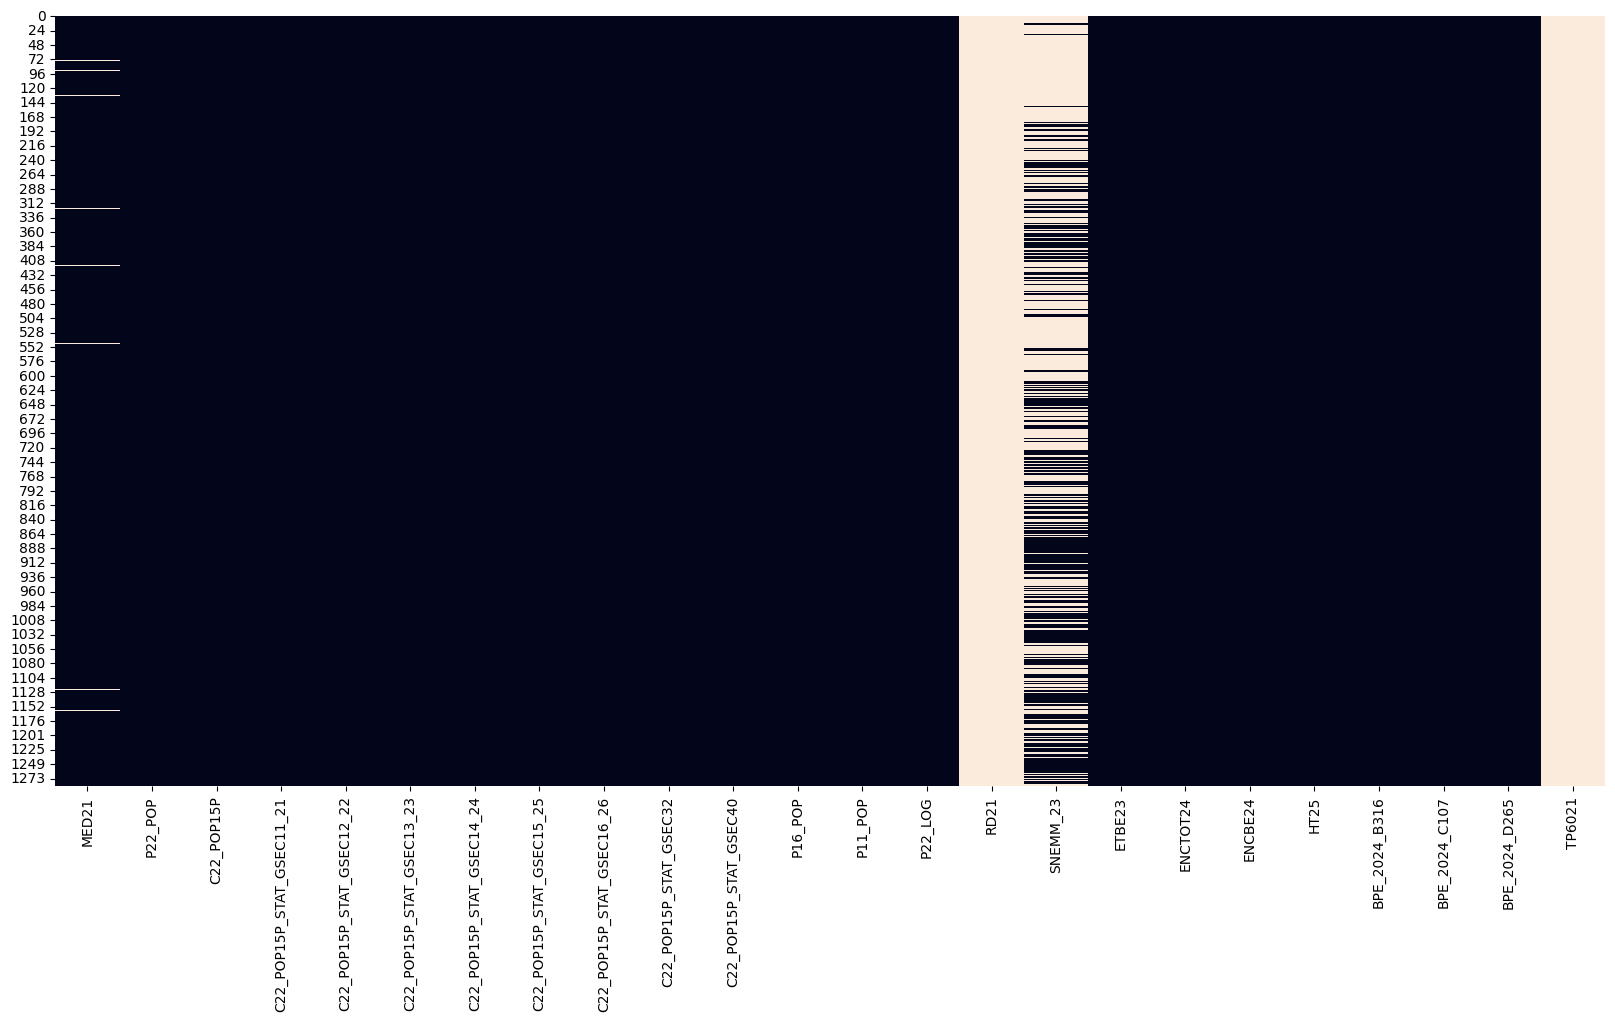

In [58]:
#### On cherche maintenant à trier dans nos variables d'intérêt : on regarde nos variables démographiques et on visualise les NAs

# On crée un df avec les variables démographiques d'intérêt
communes_idf_dem = communes_idf[["MED21", "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "RD21", "SNEMM_23", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265", "TP6021"]]

# On transforme les "s" (convention INSEE) en NAs (ce qu'ils signifient) - cela ne concerne que TP6021 et RD21 (les autres sont déjà des float)
communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
communes_idf_dem["MED21"] = pd.to_numeric(communes_idf_dem["MED21"], errors='coerce')

# On visualise les NAs
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_dem.isna(), cbar=False)

In [49]:
# On regarde les NAs
communes_idf_dem.isna().sum()

MED21                          15
P22_POP                         0
C22_POP15P                      0
C22_POP15P_STAT_GSEC11_21       0
C22_POP15P_STAT_GSEC12_22       0
C22_POP15P_STAT_GSEC13_23       0
C22_POP15P_STAT_GSEC14_24       0
C22_POP15P_STAT_GSEC15_25       0
C22_POP15P_STAT_GSEC16_26       0
C22_POP15P_STAT_GSEC32          0
C22_POP15P_STAT_GSEC40          0
P16_POP                         0
P11_POP                         0
P22_LOG                         0
RD21                         1285
SNEMM_23                      739
ETBE23                          0
ENCTOT24                        0
ENCBE24                         0
HT25                            0
BPE_2024_B316                   0
BPE_2024_C107                   0
BPE_2024_D265                   0
TP6021                       1285
dtype: int64

In [59]:
#### On réduit, à titre provisoire, notre df total à quelques variables d'intérêt (sans TP601, RD21 ni SNEMM_23 à cause des NAs)

# On sélectionne les variables
communes_idf_short = communes_idf.copy()
communes_idf_short = communes_idf_short[[
    
    # Variables descriptives
"insee", "nom", "departement", "densite", "surf_ha", "geometry", "centroid", "x", "y",

    # Variables démographiques (dossier complet de l'insee)
"MED21", "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265",

    # Variables liées à la pollution
"Polluee", "rejets_isoles", "nb_etablissements_isoles", "rejets_raccordes", "nb_etablissements_raccordes", "rejets_tot", "nb_etablissements_tot",
"no2", "o3", "pm10"]]

In [64]:
## Nettoyage

# On transforme le revenu médian en variable numérique
communes_idf_short["MED21"] = pd.to_numeric(communes_idf_short["MED21"], errors='coerce')

# On nettoie le revenu médian en supprimant les (15) lignes non renseignées
communes_idf_short = communes_idf_short.dropna(subset=['MED21'])

# On supprime la ville de Pierrefitte (dont on a remarqué qu'elle est la seule pour laquelle P22_POP n'est pas renseignée)
communes_idf = communes_idf[communes_idf["insee"] != "93059"]

<Axes: >

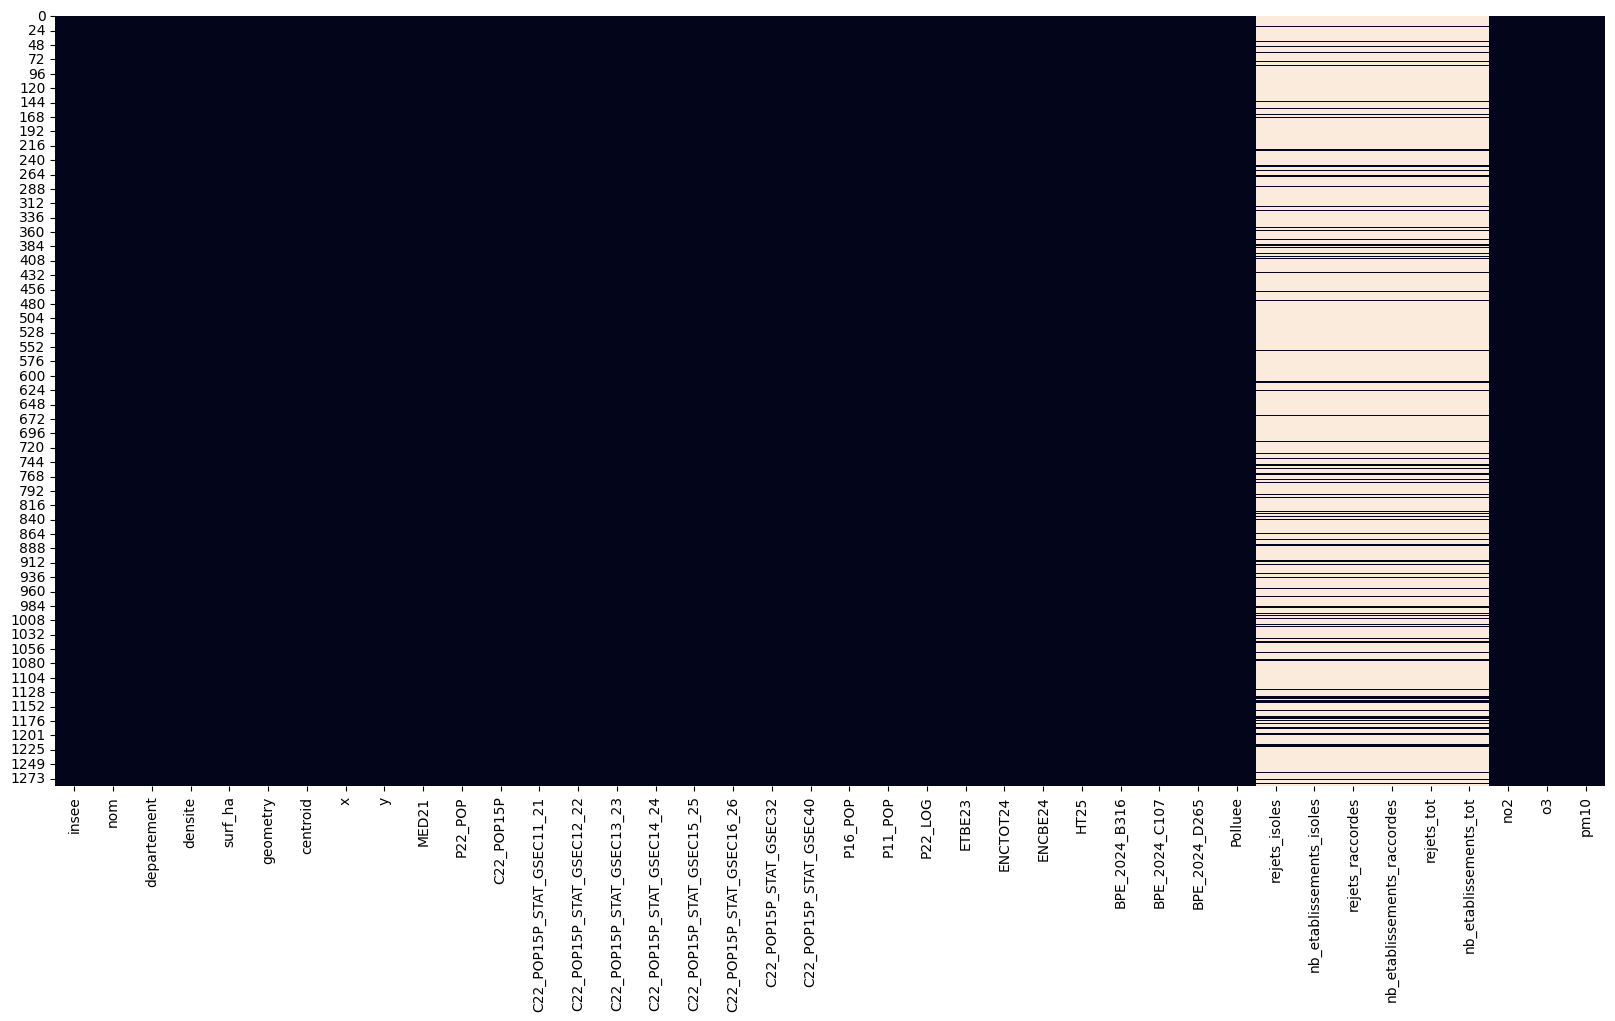

In [61]:
# On visualise les valeurs manquantes (aucune sauf pour les rejets - car NA = 0 ici)
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_short.isna(), cbar=False)

In [ ]:
####################################################
####### PARTIE 3 : STATISTIQUES DESCRIPTIVES #######
####################################################

In [62]:
communes_idf_short.dtypes

insee                            object
nom                              object
departement                      object
densite                         float64
surf_ha                         float64
geometry                       geometry
centroid                       geometry
x                               float64
y                               float64
MED21                            object
P22_POP                         float64
C22_POP15P                      float64
C22_POP15P_STAT_GSEC11_21       float64
C22_POP15P_STAT_GSEC12_22       float64
C22_POP15P_STAT_GSEC13_23       float64
C22_POP15P_STAT_GSEC14_24       float64
C22_POP15P_STAT_GSEC15_25       float64
C22_POP15P_STAT_GSEC16_26       float64
C22_POP15P_STAT_GSEC32          float64
C22_POP15P_STAT_GSEC40          float64
P16_POP                         float64
P11_POP                         float64
P22_LOG                         float64
ETBE23                          float64
ENCTOT24                        float64


In [63]:
#### Quelques corrélations

# Avec le revenu médian
communes_idf_short["pm10"].corr(communes_idf_short["MED21"])
communes_idf_short["o3"].corr(communes_idf_short["MED21"])
communes_idf_short["no2"].corr(communes_idf_short["MED21"])

# Avec la taille de la commune
communes_idf_short["pm10"].corr(communes_idf_short["P22_POP"])
communes_idf_short["o3"].corr(communes_idf_short["P22_POP"])
communes_idf_short["no2"].corr(communes_idf_short["P22_POP"])


ValueError: could not convert string to float: 's'

In [ ]:
##############################################
########## PARTIE 4 : VISUALISATIONS #########
##############################################

In [36]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 77.5 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [contextily]9 [geopy]io]


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

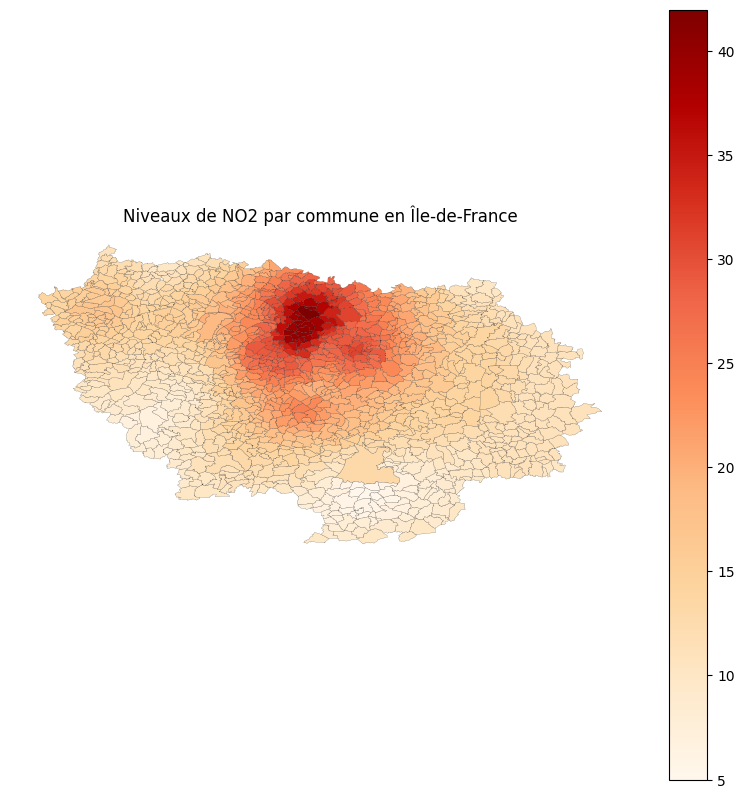

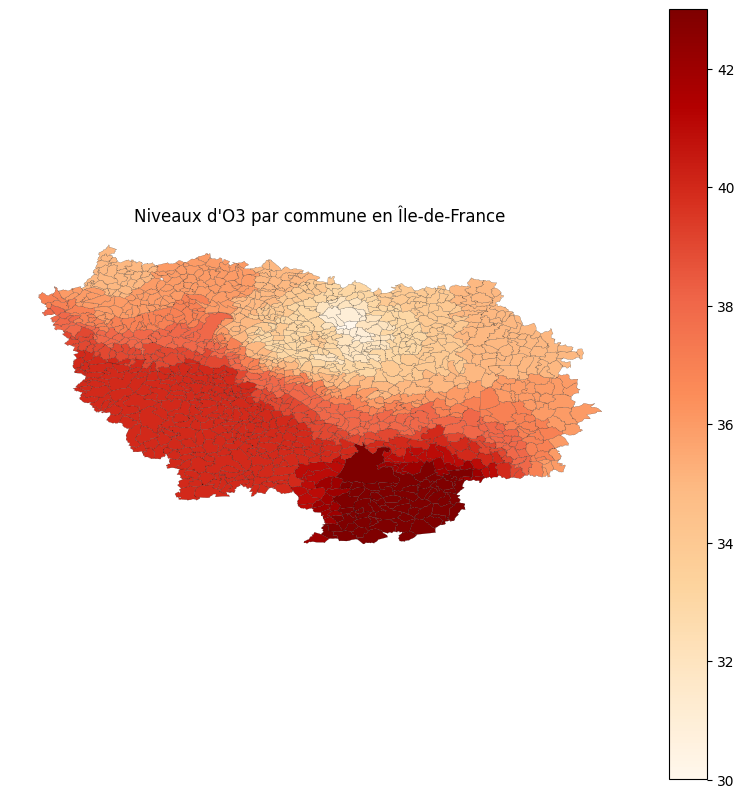

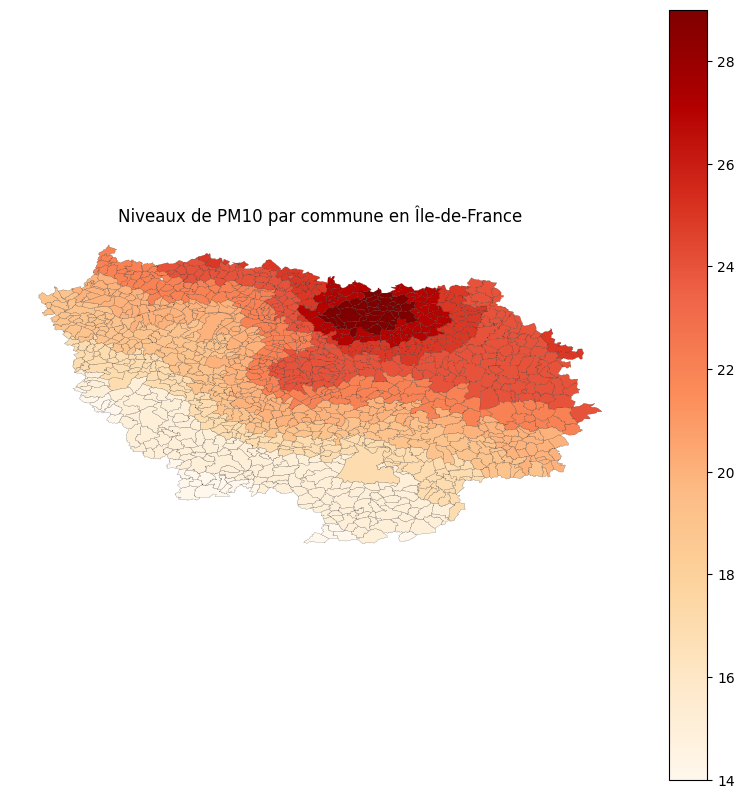

In [38]:
# NO2
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="no2",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux de NO2 par commune en Île-de-France")
ax.axis("off")

# 03
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="o3",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux d'O3 par commune en Île-de-France")
ax.axis("off")

# PM10
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="pm10",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Niveaux de PM10 par commune en Île-de-France")
ax.axis("off")

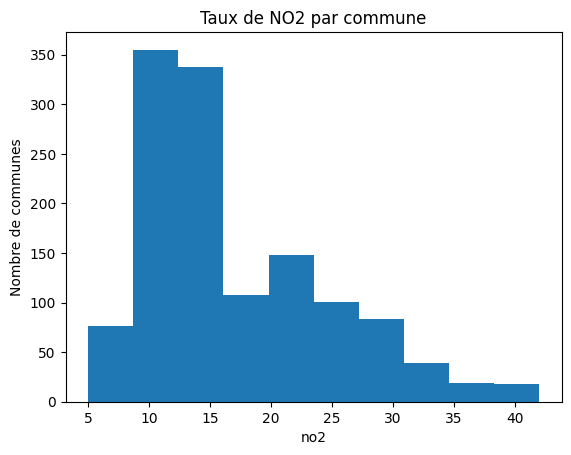

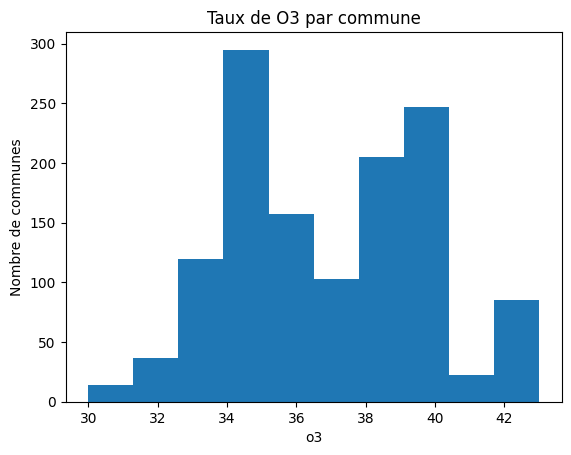

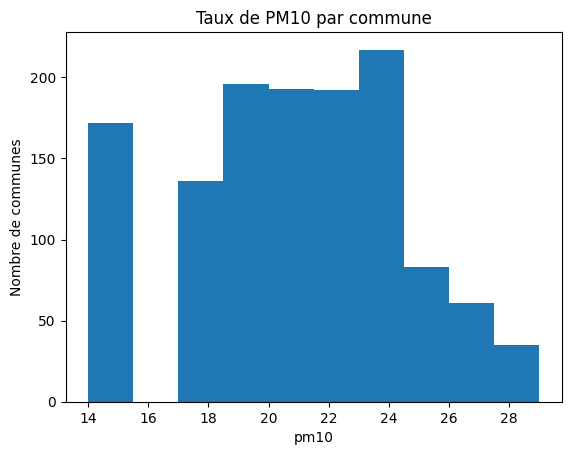

In [65]:
# NO2
plt.hist(communes_idf["no2"])
plt.xlabel("no2")
plt.ylabel("Nombre de communes")
plt.title("Taux de NO2 par commune")
plt.show()

# O3
plt.hist(communes_idf["o3"])
plt.xlabel("o3")
plt.ylabel("Nombre de communes")
plt.title("Taux de O3 par commune")
plt.show()

# PM10
plt.hist(communes_idf["pm10"])
plt.xlabel("pm10")
plt.ylabel("Nombre de communes")
plt.title("Taux de PM10 par commune")
plt.show()

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

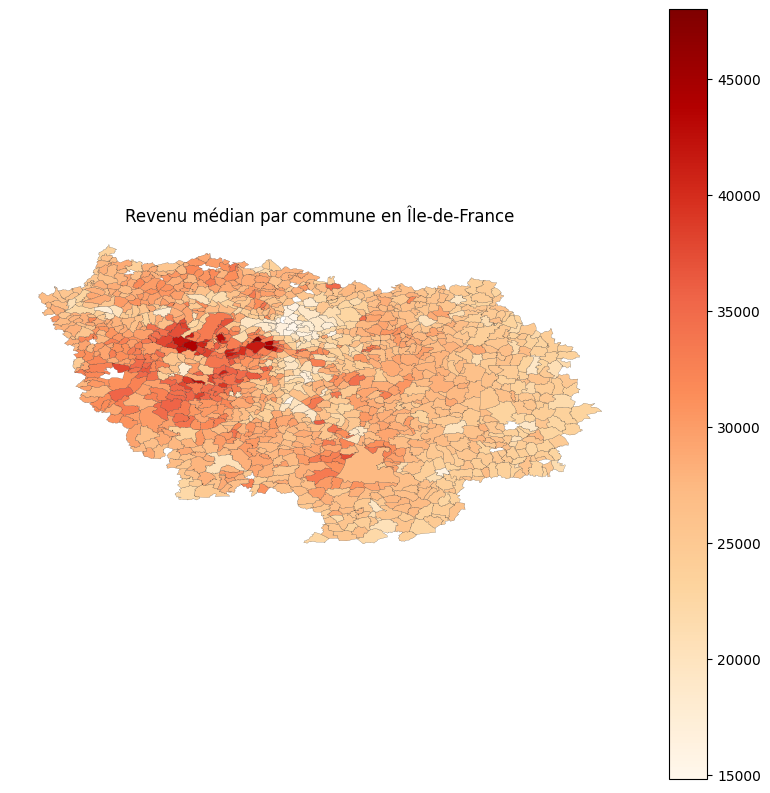

In [66]:
# Revenu médian

communes_idf_short["MED21"] = communes_idf_short["MED21"].astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="MED21",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Revenu médian par commune en Île-de-France")
ax.axis("off")

In [ ]:
##############################################
######### PARTIE 5 : MODELISATION ############
##############################################

In [41]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [ ]:
### PARAGRAPHE 1 : régressions de la qualité de l'air (pm10, o3, no2) sur des variables démographiques et spatiales

In [ ]:
## On régresse PM10 sur plein de variables

# Variable dépendante
y_pm10 = communes_idf_short['pm10']

# Variables explicatives
X_dem = communes_idf_short[['surf_ha', 'MED21', 'densite', 'Polluee', "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22",
"C22_POP15P_STAT_GSEC13_23", "C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32",
"C22_POP15P_STAT_GSEC40", "P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316",
"BPE_2024_C107", "BPE_2024_D265"]]

# Standardiser les colonnes continues
scaler = StandardScaler()
X_dem_scaled = pd.DataFrame(scaler.fit_transform(X_dem[['surf_ha', 'MED21', 'densite', "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22",
"C22_POP15P_STAT_GSEC13_23", "C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32",
"C22_POP15P_STAT_GSEC40", "P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316",
"BPE_2024_C107", "BPE_2024_D265"]]),

                        columns=['surf_ha', 'MED21', 'densite', "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22",
"C22_POP15P_STAT_GSEC13_23", "C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32",
"C22_POP15P_STAT_GSEC40", "P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316",
"BPE_2024_C107", "BPE_2024_D265"],
                        index=X_dem.index)

# On ajoute la variable binaire sans standardisation
X_dem_scaled['Polluee'] = X_dem['Polluee'].astype(int)

# On ajoute l'intercept
X_dem_const = sm.add_constant(X_dem_scaled)

# Construction et ajustement du modèle
model_pm10_dem_std = sm.OLS(y_pm10, X_dem_const).fit()

# Résumé complet
print(model_pm10_dem_std.summary())

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     7.797
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           3.37e-24
Time:                        14:11:53   Log-Likelihood:                -3373.5
No. Observations:                1270   AIC:                             6795.
Df Residuals:                    1246   BIC:                             6918.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [73]:
# On affiche les VIF (VIF > 5 : variable très corrélées aux autres variables du modèle)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_dem_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_dem_scaled.values, i) for i in range(X_dem_scaled.shape[1])]
print(vif_data)

                      feature          VIF
0                     surf_ha     1.255713
1                       MED21     1.721848
2                     densite     4.147476
3                     P22_POP  4204.374120
4                  C22_POP15P          inf
5   C22_POP15P_STAT_GSEC11_21          inf
6   C22_POP15P_STAT_GSEC12_22          inf
7   C22_POP15P_STAT_GSEC13_23          inf
8   C22_POP15P_STAT_GSEC14_24          inf
9   C22_POP15P_STAT_GSEC15_25          inf
10  C22_POP15P_STAT_GSEC16_26          inf
11     C22_POP15P_STAT_GSEC32          inf
12     C22_POP15P_STAT_GSEC40          inf
13                    P16_POP  2120.320895
14                    P11_POP  1127.828999
15                    P22_LOG   480.522301
16                     ETBE23    14.297223
17                   ENCTOT24    30.070655
18                    ENCBE24    29.843662
19                       HT25     5.823738
20              BPE_2024_B316     2.895152
21              BPE_2024_C107    21.573031
22         

/opt/python/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [74]:
## On écrit une fonction pour supprimer, de façon itérative, les variables avec un fort VIF (chatGPT : reprendre)

def reduce_vif(X, threshold=5):
    X = X.copy()
    
    while True:
        vif = pd.DataFrame({
            "feature": X.columns,
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })
        
        max_vif = vif["VIF"].max()
        
        if max_vif <= threshold:
            break
        
        feature_to_drop = vif.loc[vif["VIF"].idxmax(), "feature"]
        print(f"Suppression de {feature_to_drop} (VIF = {max_vif:.2f})")
        
        X = X.drop(columns=[feature_to_drop])
    
    return X

In [75]:
# On applique la fonction : on supprime une par une les variables à fort VIF (ie très corrélées entre elles)
X_for_vif = X_dem_scaled.drop(columns=['Polluee'])
X_dem_reduced = reduce_vif(X_for_vif, threshold=5)
X_dem_reduced['Polluee'] = X_dem_scaled['Polluee']

/opt/python/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Suppression de C22_POP15P (VIF = inf)
Suppression de P22_POP (VIF = 4182.84)


Suppression de P16_POP (VIF = 1993.71)
Suppression de P11_POP (VIF = 486.37)
Suppression de P22_LOG (VIF = 245.41)
Suppression de C22_POP15P_STAT_GSEC15_25 (VIF = 147.99)
Suppression de C22_POP15P_STAT_GSEC14_24 (VIF = 64.99)
Suppression de C22_POP15P_STAT_GSEC32 (VIF = 48.40)
Suppression de C22_POP15P_STAT_GSEC40 (VIF = 46.58)
Suppression de ENCTOT24 (VIF = 28.18)
Suppression de C22_POP15P_STAT_GSEC12_22 (VIF = 18.79)
Suppression de BPE_2024_C107 (VIF = 14.68)
Suppression de ETBE23 (VIF = 11.16)
Suppression de C22_POP15P_STAT_GSEC13_23 (VIF = 8.01)


In [76]:
## On refait la régression avec moins de régresseurs

# On ajoute l'intercept
X_dem_reduced_const = sm.add_constant(X_dem_reduced)

# Construction et ajustement du modèle
model_pm10_dem_std_reduced = sm.OLS(y_pm10, X_dem_reduced_const).fit()

# Résumé complet
print(model_pm10_dem_std_reduced.summary())      

### REMARQUE : on a diminué les AIC et BIC mais le R^2 est toujours faible. On va faire mieux avec l'O3 et surtout le NO2.

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     13.83
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           2.21e-23
Time:                        14:12:06   Log-Likelihood:                -3392.7
No. Observations:                1270   AIC:                             6807.
Df Residuals:                    1259   BIC:                             6864.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
#### Régression du o3 sur les variables "non spatiales"

# Variable dépendante
y_o3 = communes_idf_short['o3']

# Construction et ajustement du modèle
model_o3_dem_std = sm.OLS(y_o3, X_dem_const).fit()

# Résumé complet
print(model_o3_dem_std.summary())

### REMARQUE : le R^2 est légèrement meilleur (0.164) mais pareil pour les variables (à part densité, revenu médian et surface un peu)

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     14.00
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           8.29e-48
Time:                        14:12:09   Log-Likelihood:                -3029.1
No. Observations:                1270   AIC:                             6106.
Df Residuals:                    1246   BIC:                             6230.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [78]:
## Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_o3_dem_std_reduced = sm.OLS(y_o3, X_dem_reduced_const).fit()

# Résumé complet
print(model_o3_dem_std_reduced.summary())      

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     25.52
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.93e-44
Time:                        14:12:13   Log-Likelihood:                -3057.9
No. Observations:                1270   AIC:                             6138.
Df Residuals:                    1259   BIC:                             6194.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [79]:
#### Régression du no2 sur les variables "non spatiales"

# Variable dépendante
y_no2 = communes_idf_short['no2']

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 est nettement meilleur (0.369) et quelques variables ont un rôle notable (densité, polluee, popuation, revenu médian)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     49.35
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          5.22e-157
Time:                        14:12:20   Log-Likelihood:                -3941.2
No. Observations:                1270   AIC:                             7930.
Df Residuals:                    1246   BIC:                             8054.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [80]:
#### Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_reduced_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 baisse un peu (0.424)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     92.73
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.84e-143
Time:                        14:12:23   Log-Likelihood:                -4002.0
No. Observations:                1270   AIC:                             8026.
Df Residuals:                    1259   BIC:                             8083.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
#### On réduit de pas à pas le vecteur explicatif en supprimant les variables non significatives (pour diminuer les AIC et BIC)

In [81]:
# On supprime ENCEBE24 (créations d'entreprises)
X_dem_reduced_const2 = X_dem_reduced_const.drop(columns=['ENCBE24'])  
model_no2_dem_std2 = sm.OLS(y_no2, X_dem_reduced_const2).fit()
print(model_no2_dem_std2.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     102.9
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          4.52e-144
Time:                        14:12:42   Log-Likelihood:                -4002.5
No. Observations:                1270   AIC:                             8025.
Df Residuals:                    1260   BIC:                             8076.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [82]:
# On supprime HT25 (hôtels)
X_dem_reduced_const3 = X_dem_reduced_const2.drop(columns=['HT25'])  
model_no2_dem_std3 = sm.OLS(y_no2, X_dem_reduced_const3).fit()
print(model_no2_dem_std3.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     115.8
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          4.85e-145
Time:                        14:12:53   Log-Likelihood:                -4002.7
No. Observations:                1270   AIC:                             8023.
Df Residuals:                    1261   BIC:                             8070.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [83]:
# On supprime Polluee (industries polluantes présentes)
X_dem_reduced_const4 = X_dem_reduced_const3.drop(columns=['Polluee'])  
model_no2_dem_std4 = sm.OLS(y_no2, X_dem_reduced_const4).fit()
print(model_no2_dem_std4.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     132.4
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          4.38e-146
Time:                        14:12:55   Log-Likelihood:                -4002.7
No. Observations:                1270   AIC:                             8021.
Df Residuals:                    1262   BIC:                             8063.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [84]:
# On supprime MED21 (revenu médian)
X_dem_reduced_const5 = X_dem_reduced_const4.drop(columns=['MED21'])  
model_no2_dem_std5 = sm.OLS(y_no2, X_dem_reduced_const5).fit()
print(model_no2_dem_std5.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     154.3
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          5.74e-147
Time:                        14:12:58   Log-Likelihood:                -4003.3
No. Observations:                1270   AIC:                             8021.
Df Residuals:                    1263   BIC:                             8057.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [85]:
### On ajoute à la régression les coordonnées géographiques pour voir si cela annule tout le reste

# On crée le df démographique et spatial
X_dem_spatial = X_dem_reduced_const5
X_dem_spatial[["x", "y"]] = communes_idf_short[["x", "y"]]

# on standardise
scaler = StandardScaler()
X_dem_spatial[["x", "y"]] = scaler.fit_transform(X_dem_spatial[["x", "y"]])

# On construit le modèle
model_no2_dem_spatial = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial.summary())

### REMARQUE : au total, x et y augmentent nettement le R^2 mais n'écrasent pas le reste.

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     200.1
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.93e-218
Time:                        14:13:01   Log-Likelihood:                -3832.0
No. Observations:                1270   AIC:                             7682.
Df Residuals:                    1261   BIC:                             7728.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [86]:
### On ajoute l'effet croisé x*y

# Nouvelle variable
X_dem_spatial['densite_surf'] = X_dem_spatial['densite'] * X_dem_spatial['surf_ha']

# On construit le modèle
model_no2_dem_spatial2 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial2.summary())

### REMARQUE : l'effet croisé semble fort et augmente un peu le R^2 (grandes villes et denses = les plus polluées)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     181.9
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          1.13e-220
Time:                        14:13:05   Log-Likelihood:                -3823.7
No. Observations:                1270   AIC:                             7667.
Df Residuals:                    1260   BIC:                             7719.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

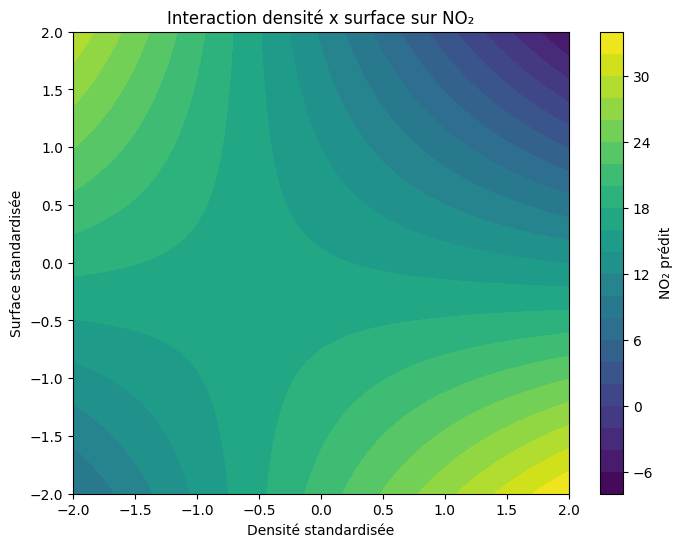

In [87]:
#### On visualise l'effet croisé surface / densité

# On récupère les coefs de la dernière régression
coef = model_no2_dem_spatial2.params

# On crée des séries de 50 valeurs pour discrétiser nos valeurs de densité et de surface (entre -2 et 2 écarts-types)
dens_vals = np.linspace(-2, 2, 50)
surf_vals = np.linspace(-2, 2, 50)

# On récupère toutes les combinaisons possibles, dans une matrice 2D, entre surface et densité
D, S = np.meshgrid(dens_vals, surf_vals)

# On prédit NO2 à partir des coefs pour chaque ligne
NO2_pred = (
    coef["const"] +
    coef["densite"] * D +
    coef["surf_ha"] * S +
    coef["densite_surf"] * D * S
)

# On représente les effets croisés
plt.figure(figsize=(8,6))
cp = plt.contourf(D, S, NO2_pred, levels=20, cmap='viridis')
plt.colorbar(cp, label='NO₂ prédit')
plt.xlabel('Densité standardisée')
plt.ylabel('Surface standardisée')
plt.title('Interaction densité x surface sur NO₂')
plt.show()

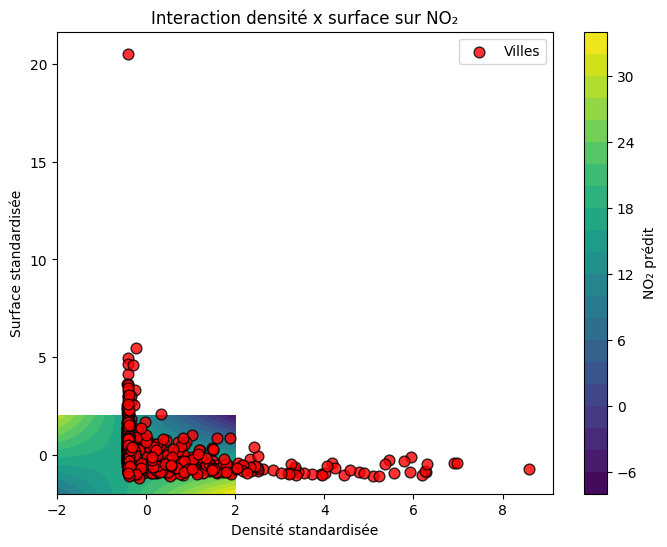

In [ ]:
densite = X_dem_spatial["densite"]
surf_ha = X_dem_spatial["surf_ha"]

# On récupère les coefs de la dernière régression
coef = model_no2_dem_spatial2.params

# On crée des séries de 50 valeurs pour discrétiser nos valeurs de densité et de surface (entre -2 et 2 écarts-types)
dens_vals = np.linspace(-2, 2, 50)
surf_vals = np.linspace(-2, 2, 50)

# On récupère toutes les combinaisons possibles, dans une matrice 2D, entre surface et densité
D, S = np.meshgrid(dens_vals, surf_vals)

# On prédit NO2 à partir des coefs pour chaque ligne
NO2_pred = (
    coef["const"] +
    coef["densite"] * D +
    coef["surf_ha"] * S +
    coef["densite_surf"] * D * S
)

plt.figure(figsize=(8,6))

cp = plt.contourf(D, S, NO2_pred, levels=20, cmap='viridis')
plt.colorbar(cp, label='NO₂ prédit')

# Ajout des villes
plt.scatter(
    densite,
    surf_ha,
    color='red',
    edgecolor='black',
    s=60,
    alpha=0.8,
    label='Villes'
)

plt.xlabel('Densité standardisée')
plt.ylabel('Surface standardisée')
plt.title('Interaction densité x surface sur NO₂')
plt.legend()
plt.show()

(array([18.1635021 ,  8.42681708,  3.97326608,  2.35776229,  1.44085473,
         1.44085473,  1.00423209,  0.61127171,  0.82958303,  0.48028491,
         0.65493397,  0.61127171,  0.56760944,  0.34929812,  0.21831132,
         0.39296038,  0.34929812,  0.43662265,  0.34929812,  0.30563585,
         0.17464906,  0.13098679,  0.21831132,  0.43662265,  0.17464906,
         0.17464906,  0.13098679,  0.13098679,  0.04366226,  0.26197359,
         0.08732453,  0.21831132,  0.21831132,  0.21831132,  0.04366226,
         0.39296038,  0.17464906,  0.21831132,  0.17464906,  0.08732453,
         0.30563585,  0.26197359,  0.08732453,  0.08732453,  0.04366226,
         0.26197359,  0.08732453,  0.21831132,  0.13098679,  0.08732453,
         0.13098679,  0.08732453,  0.17464906,  0.04366226,  0.08732453,
         0.08732453,  0.08732453,  0.08732453,  0.04366226,  0.04366226,
         0.        ,  0.17464906,  0.08732453,  0.17464906,  0.04366226,
         0.08732453,  0.08732453,  0.04366226,  0.0

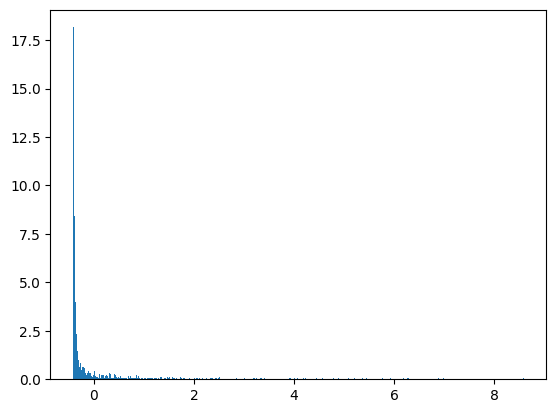

In [110]:
plt.hist(densite, bins=500, density=True)